<a href="https://colab.research.google.com/github/luyuzhe111/machine-learning-foundamentals/blob/main/gaussian_mixture_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal

In [2]:
with open('hw4_p2.pkl', 'rb') as f:
    data = pickle.load(f)

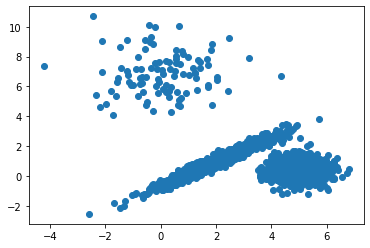

In [3]:
plt.scatter(data[:, 0], data[:, 1])

In [4]:
class GMM:
  def __init__(self, k, n_iter=5):
    self.k = k
    self.n_iter = n_iter
    self.likelihoods = []

  def init(self, X):
    self.shape = X.shape
    self.n, self.m = X.shape

    self.alphas = np.ones((self.k, )) / self.k
    self.probs = np.ones(self.shape) / self.k
    
    rand_inds = np.random.randint(low=0, high=self.n, size=self.k)
    self.mu = [X[i,:] for i in rand_inds]
    self.sigma = [np.cov(X.T) for _ in range(self.k)]
  
  def compute_prob(self, X):
    likelihood = np.zeros((self.n, self.k))
    for i in range(self.k):
      distribution = multivariate_normal(mean=self.mu[i], cov=self.sigma[i])
      likelihood[:,i] = distribution.pdf(X)
    
    self.likelihoods.append(likelihood.mean())
    
    numerator = likelihood * self.alphas
    denominator = numerator.sum(1)[:, None]
    probs = numerator / denominator
    return probs

  def expectation(self, X):
    self.probs = self.compute_prob(X)
  
  def maximization(self, X):
    self.alphas = self.probs.mean(0)
    for i in range(self.k):
      prob = self.probs[:, [i]]
      k_prob = prob.sum()
      self.mu[i] = (X * prob).sum(0) / k_prob
      self.sigma[i] = np.cov(X.T, aweights=(prob / k_prob).flatten())

  def fit(self, X):
    self.init(X)
    for _ in range(self.n_iter):
      self.expectation(X)
      self.maximization(X) 

In [5]:
n_iter = 20
gmm = GMM(k=3, n_iter=n_iter)
gmm.fit(data)

### Data likelihoods 

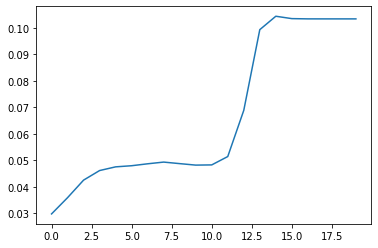

In [6]:
plt.plot(range(n_iter), gmm.likelihoods)
plt.show()

### Learned GMM

In [7]:
mu = np.stack(gmm.mu,axis=0)
sigma = np.stack(gmm.sigma,axis=0)

In [8]:
def draw_conf2D(mu,Sigma,ax,n_std=2,**kwargs):
  for i in range(mu.shape[0]):
    pearson = Sigma[i,0,1]/np.sqrt(Sigma[i,0,0] * Sigma[i,1,1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2)
                      
    scale_x = np.sqrt(Sigma[i,0,0]) * n_std
    mean_x = mu[i,0]

    scale_y = np.sqrt(Sigma[i,1,1]) * n_std
    mean_y = mu[i,1]

    transf = transforms \
      .Affine2D() \
      .rotate_deg(45) \
      .scale(scale_x, scale_y) \
      .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

[]

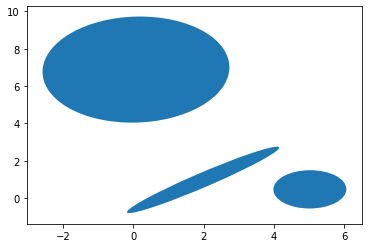

In [9]:
fig, ax = plt.subplots()
draw_conf2D(mu, sigma, ax)
ax.scatter(mu[:, 0], mu[:, 1], c='r')
ax.plot()